# Course work

## Task
Marketing campaigns are an essential part of the business. This is also true for banking services. Meanwhile, the estimation of marketing campaign performance and prediction of performance is a challenging task. Based on historical data related to direct marketing campaigns of a Portuguese banking institution try to predict subscription for deposit

Metrics:
As for subscription prediction, we can't prefer precision or recall and the task is about binary classification, ROC AUC score will be used.
*   ROC AUC score maximization
*   ROC AUC score >= 80%

Dataset for research available [here](https://archive.ics.uci.edu/dataset/222/bank+marketing)

## Product questions
We need to build a prediction model, depending on the usage of this model we could differently use our train data. So we need to understand:
- Will the model be trained and used once before the campaign started to predict results? In this case, we can't train our model with data about the current marketing campaign
- Will the model be used continuously during the marketing campaign for every single user and our prediction about success will change with any new data incoming (like new contact information during the current campaign)? In this case, the whole dataset is applicable. But at what point (monitoring metrics) we should retrain our model as we have more historical data
- Marketing campaigns can have specifics like end and start date, do we have a dataset that covers the whole timeline of the previous campaign?

To find out answers we need to keep in mind the workflow of the user, who will use the model.

I will go with the assumption that the model will be used continuously during one campaign and re-run predictions for specific user on every data update. After the final result (answer yes or no) model metrics will be recalculated and if it is below baseline retrain happen.  

## EDA

In [29]:
import warnings
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib
plt = matplotlib.pyplot

warnings.filterwarnings('ignore')

sns.set_theme()

print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"missingno: {msno.__version__}")
print(f"numpy: {np.__version__}")

pandas: 1.5.3
seaborn: 0.12.2
missingno: 0.5.2
numpy: 1.22.4


In [4]:
url = 'https://raw.githubusercontent.com/dmytrovelychko/rd_ds_python/main/datasets/bank-additional-full.csv'
df = pd.read_csv(url, sep=";")
print(f"shape: {df.shape}")
df[:100]

shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45,services,married,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
96,42,management,married,university.degree,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
97,53,admin.,divorced,university.degree,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
98,37,technician,single,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Dataset description
**bank client data:**
   - age (numeric)
   - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   - default: has credit in default? (categorical: "no","yes","unknown")
   - housing: has housing loan? (categorical: "no","yes","unknown")
   - loan: has personal loan? (categorical: "no","yes","unknown")

**related with the last contact of the current campaign:**
   - contact: contact communication type (categorical: "cellular","telephone")
   - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
  - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  - previous: number of contacts performed before this campaign and for this client (numeric)
  - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
  **social and economic context attributes**
  - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  - cons.price.idx: consumer price index - monthly indicator (numeric)     
  - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  - euribor3m: euribor 3 month rate - daily indicator (numeric)
  - nr.employed: number of employees - quarterly indicator (numeric)

**  Output variable (desired target):**
  - y - has the client subscribed a term deposit? (binary: "yes","no")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

no empty values set as n/a

Text(0.5, 0, 'y (subscription result)')

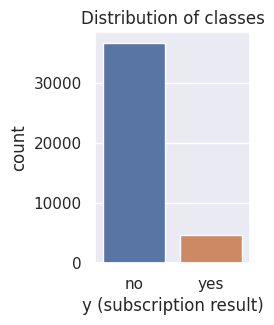

In [89]:
plt.figure(figsize=(2,3))
sns.countplot(x=df['y'])
plt.title('Distribution of classes')
plt.xlabel('y (subscription result)')

Highly imbalanced classes of taget feature

### Numerical features


In [42]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### age

Text(0.5, 1.0, 'Distribution of users by age')

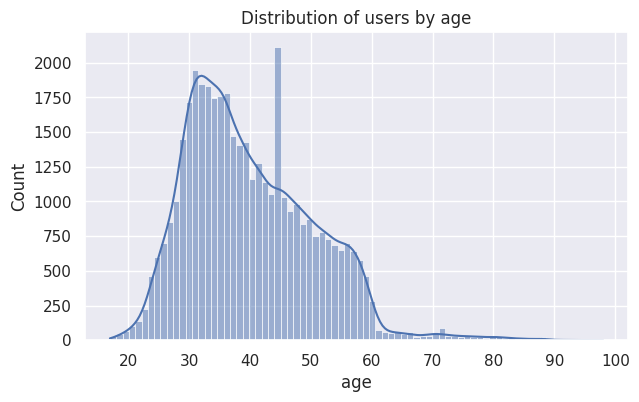

In [92]:
plt.figure(figsize=(7,4))
sns.histplot(df['age'], bins=len(df['age'].unique()), kde=True)
plt.title('Distribution of users by age')

- most if the users 25<age<60

Text(0.5, 0, 'age')

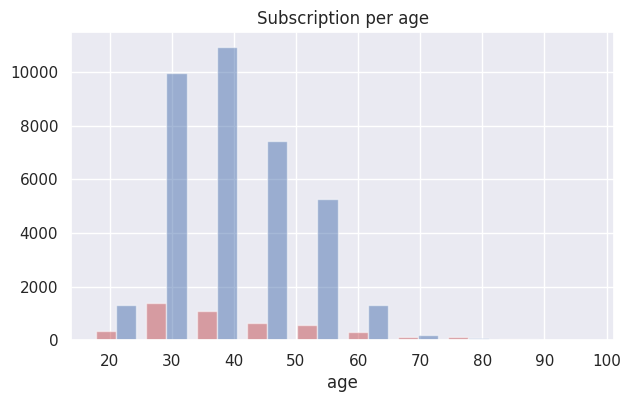

In [94]:
plt.figure(figsize=(7,4))
plt.hist([df[df['y'] == 'yes']['age'], df[df['y'] == 'no']['age']], color=['r','b'], alpha=0.5)
plt.title('Subscription per age')
plt.xlabel('age')

- highest subscription count for near age = 30
- more younger more tend to subscribe for age >= 25

Text(0.5, 1.0, 'Outliers for age')

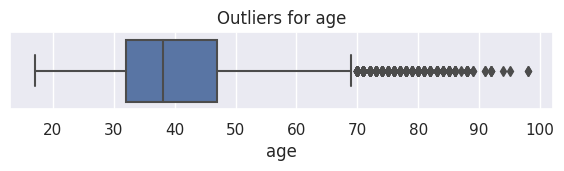

In [100]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x="age")
plt.title('Outliers for age')

Text(0, 0.5, 'subscription')

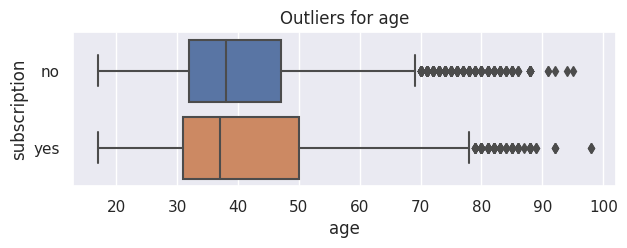

In [101]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="age", y="y")
plt.title('Outliers for age')
plt.ylabel('subscription')

- outliers candidates are with age>=70

In [79]:
print(df[df['age'] >= 70].shape)
df[df['age'] >= 70].sort_values('age').tail()

(469, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
40469,92,retired,married,unknown,no,no,yes,cellular,aug,wed,...,1,3,4,success,-1.7,94.027,-38.3,0.903,4991.6,yes
38921,94,retired,married,basic.9y,no,no,no,cellular,nov,wed,...,1,999,1,failure,-3.4,92.649,-30.1,0.716,5017.5,no
27826,95,retired,divorced,basic.6y,no,no,no,cellular,mar,thu,...,1,999,0,nonexistent,-1.8,92.843,-50.0,1.650,5099.1,no
38455,98,retired,married,basic.4y,unknown,yes,no,cellular,oct,fri,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.730,5017.5,yes
38452,98,retired,married,basic.4y,unknown,yes,no,cellular,oct,fri,...,1,2,2,success,-3.4,92.431,-26.9,0.730,5017.5,yes


- outliers by age doesn't provide any unsual patterns, small amount can be dropped if needed by later checks

#### duration

In [47]:
df['duration'] = df["duration"] / 60 # convert seconds to min

Text(0.5, 1.0, 'Distribution of users by duration')

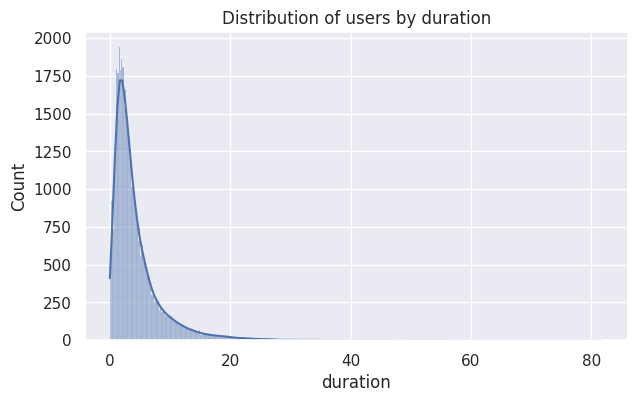

In [102]:
plt.figure(figsize=(7,4))
sns.histplot(df['duration'], kde=True)
plt.title('Distribution of users by duration')

In [54]:
df_duration_lt_20 = df[df['duration'] < 20]

Text(0.5, 0, 'duration')

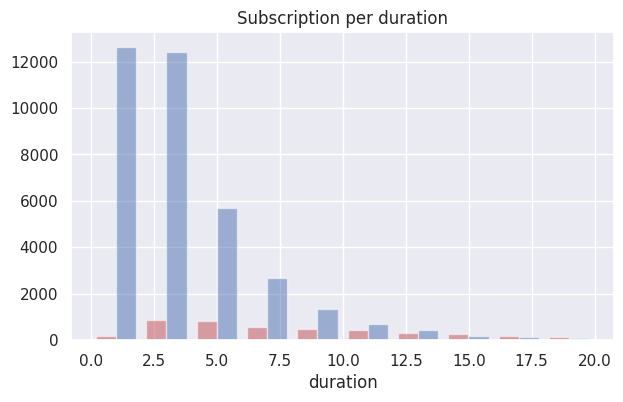

In [103]:
plt.figure(figsize=(7,4))
plt.hist([df_duration_lt_20[df_duration_lt_20['y'] == 'yes']['duration'], df_duration_lt_20[df_duration_lt_20['y'] == 'no']['duration']], color=['r','b'], alpha=0.5)
plt.title('Subscription per duration')
plt.xlabel('duration')

Data about call duration is just for notes, we will note use it in prediction model as this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. In short we can't provide this data to our model before we started the call

#### campaign

Text(0.5, 1.0, 'Distribution by number of contacts during campaign')

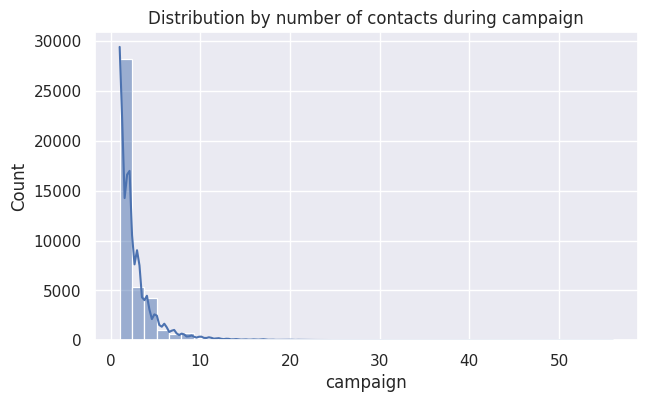

In [104]:
plt.figure(figsize=(7,4))
sns.histplot(df['campaign'], bins=40, kde=True)
plt.title('Distribution by number of contacts during campaign')

Text(0.5, 1.0, 'Distribution by number of contacts during campaign')

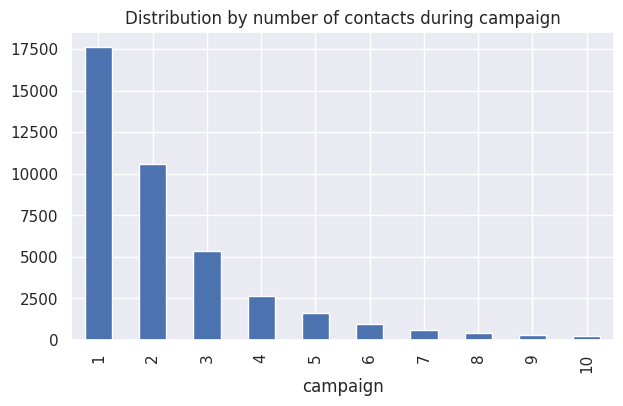

In [105]:
plt.figure(figsize=(7,4))
df[df['campaign'] <= 10].groupby('campaign').count()['y'].plot.bar()
plt.title('Distribution by number of contacts during campaign')

Text(0.5, 0, 'campaign')

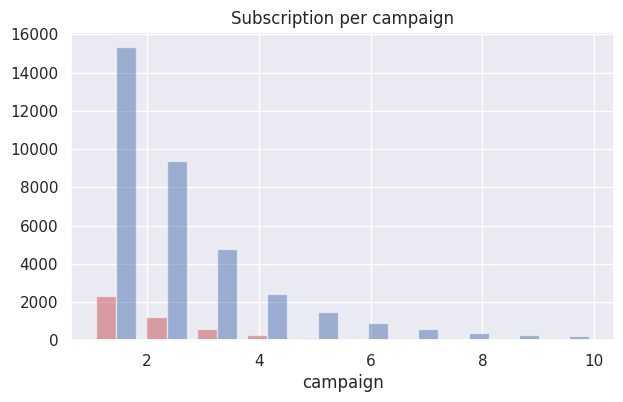

In [106]:
plt.figure(figsize=(7,4))
df_campain_lte_10 = df[df['campaign'] <= 10]
plt.hist([df_campain_lte_10[df_campain_lte_10['y'] == 'yes']['campaign'], df_campain_lte_10[df_campain_lte_10['y'] == 'no']['campaign']], color=['r','b'], alpha=0.5)
plt.title('Subscription per campaign')
plt.xlabel('campaign')

- current campagin historical data has mosly <=3 contacts during campaign
- less contacts per user more subscriptions
- a lot of contacts with the same user don't provide higher subscription rate

Text(0.5, 1.0, 'Outliers for campaign')

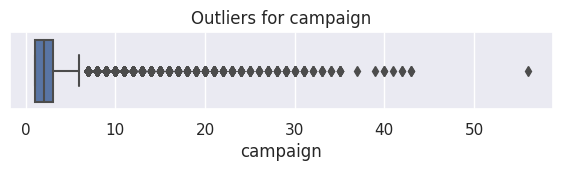

In [107]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x="campaign")
plt.title('Outliers for campaign')

Text(0, 0.5, 'subscription')

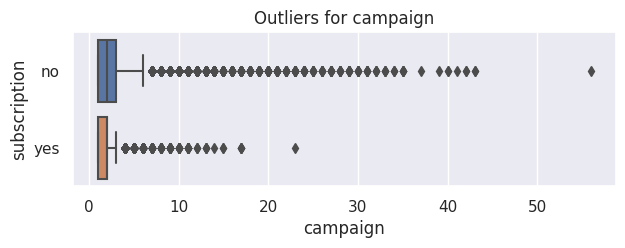

In [108]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="campaign", y="y")
plt.title('Outliers for campaign')
plt.ylabel('subscription')

let's check tail of outliers by campaign

In [85]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [88]:
df[df['campaign'] > 35][['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']]

,age,job,marital,education,default,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4107,32,admin.,married,university.degree,unknown,unknown,unknown,telephone,56,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
4114,52,entrepreneur,married,university.degree,no,no,no,telephone,39,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
4168,29,technician,married,professional.course,no,yes,no,telephone,42,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
5304,44,retired,married,basic.9y,no,yes,no,telephone,42,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11033,38,blue-collar,married,basic.4y,no,yes,no,telephone,41,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
11593,43,technician,married,high.school,no,yes,no,telephone,37,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
11769,56,self-employed,married,professional.course,no,no,yes,telephone,40,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
13447,32,technician,single,university.degree,no,yes,yes,telephone,43,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18728,54,admin.,married,university.degree,unknown,yes,no,cellular,43,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18754,36,admin.,single,university.degree,no,no,no,cellular,40,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


After several iteration can say:
- respondens have simialar social and economic attributes
- all not subscribed
- doesn't look as invalid or wrong data

#### pdays

Text(0.5, 1.0, 'Distribution by pdays')

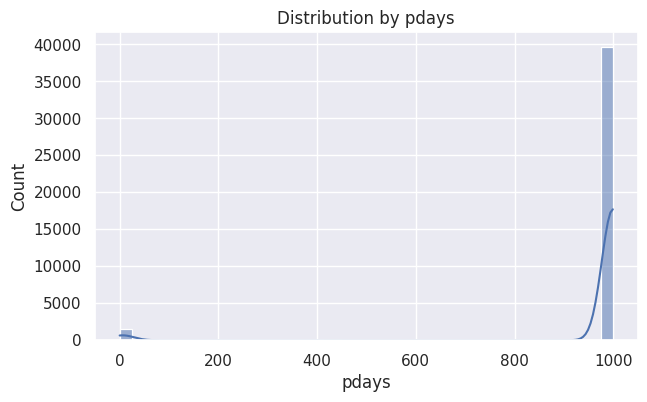

In [109]:
plt.figure(figsize=(7,4))
sns.histplot(df['pdays'], bins=40, kde=True)
plt.title('Distribution by pdays')

pdays=999 means no contacts, let's filter out this data

Text(0.5, 1.0, 'Distribution by pdays')

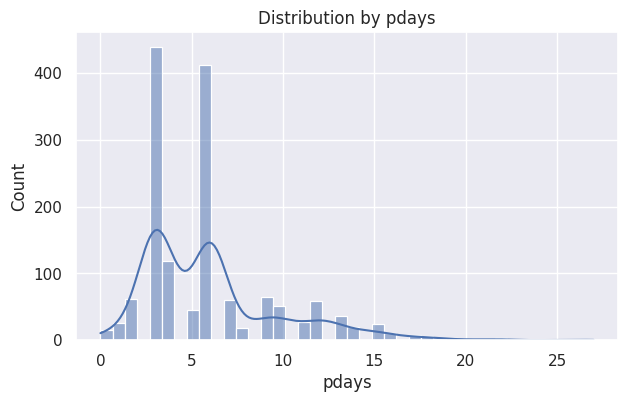

In [110]:
df_pdays_neq_999 = df[df['pdays'] < 999]
plt.figure(figsize=(7,4))
sns.histplot(df_pdays_neq_999['pdays'], bins=40, kde=True)
plt.title('Distribution by pdays')

In [112]:
count_pdays_neq_999 = df_pdays_neq_999.shape[0]
count_pdays_eq_999 = df[df['pdays'] == 999].shape[0]
print(f"Not contacted in previous campaign: {count_pdays_eq_999}, {count_pdays_eq_999/df.shape[0]*100}")

Not contacted in previous campaign: 39673, 96.32174419733903


Text(0, 0.5, 'subscription')

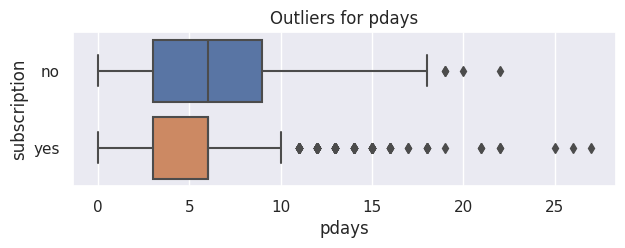

In [114]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df_pdays_neq_999, x="pdays", y="y")
plt.title('Outliers for pdays')
plt.ylabel('subscription')

- most of the client was not contacted in our dataset = 96.3%
- if client was contacted, that happened mostly not more than 17 days ago
- no strict patterns for days passed from last contact and subscriptions

#### previous

Text(0.5, 1.0, 'Distribution by number of contacts before campaign')

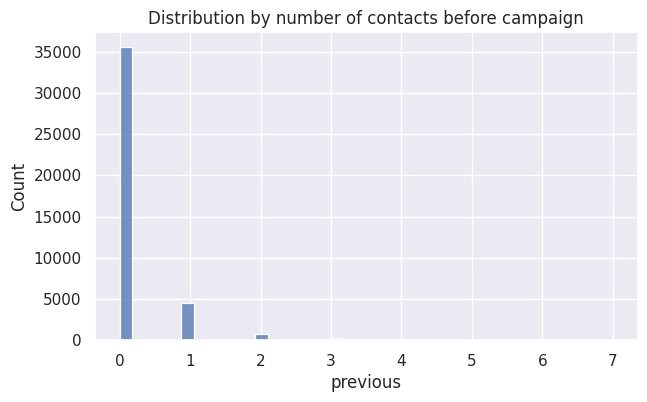

In [118]:
plt.figure(figsize=(7,4))
sns.histplot(df['previous'], bins=40)
plt.title('Distribution by number of contacts before campaign')

In [122]:
print(f"Total records with at least one contacts from previous campaign: {df[df['previous'] > 0].shape}")
print(f"Percantage: {df[df['previous'] > 0].shape[0]/df.shape[0]*100}")

Total records with at least one contacts from previous campaign: (5625, 21)
Percantage: 13.65689035641449


- we don't have much data about previous campaign only 13.5% was contacted at least once
- 13.5% still to much to just drop it, but it is possible to ignore inputs from previous campaign for better model preforming. Possible columns to drop: [pdays, previous, poutcome]

In [125]:
df_conacted_at_least_once = df[df['previous'] + df['campaign'] > 0]
print(f"Number of clients we have contacted at least once in dataset: {df_conacted_at_least_once.shape[0]}")
print(f"Percantage: {df_conacted_at_least_once.shape[0]/df.shape[0]*100}")

Number of clients we have contacted at least once in dataset: 41188
Percantage: 100.0


In [126]:
df["campaign"].min()

1

- we have contacted all clients during current campaign in dataset

#### emp.var.rate

Text(0.5, 1.0, 'Distribution by emp.var.rate')

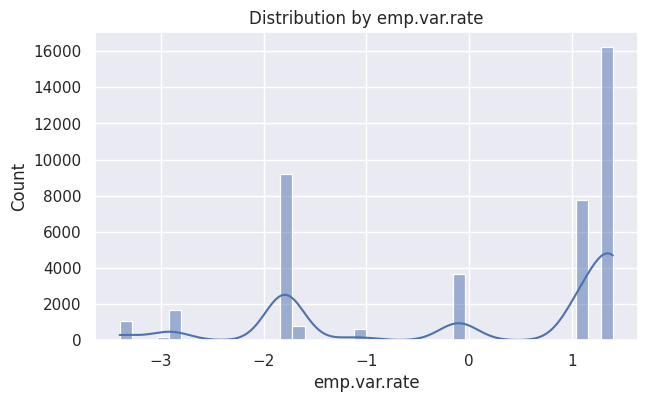

In [128]:
plt.figure(figsize=(7,4))
sns.histplot(df['emp.var.rate'], bins=40, kde=True)
plt.title('Distribution by emp.var.rate')

Text(0, 0.5, 'subscription')

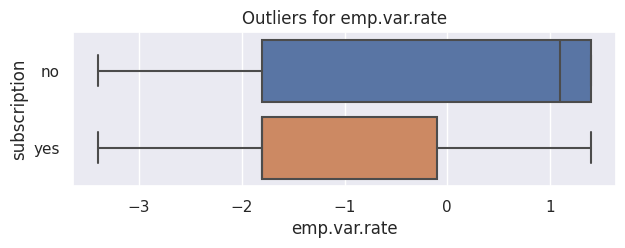

In [129]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="emp.var.rate", y="y")
plt.title('Outliers for emp.var.rate')
plt.ylabel('subscription')

#### cons.price.idx

Text(0.5, 1.0, 'Distribution by cons.price.idx')

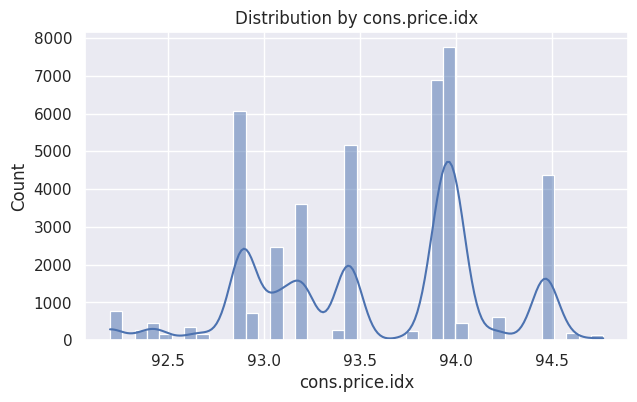

In [130]:
plt.figure(figsize=(7,4))
sns.histplot(df['cons.price.idx'], bins=40, kde=True)
plt.title('Distribution by cons.price.idx')

Text(0, 0.5, 'subscription')

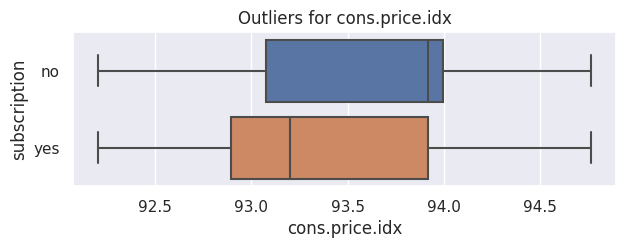

In [131]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="cons.price.idx", y="y")
plt.title('Outliers for cons.price.idx')
plt.ylabel('subscription')

#### cons.conf.idx

Text(0.5, 1.0, 'Distribution by cons.conf.idx')

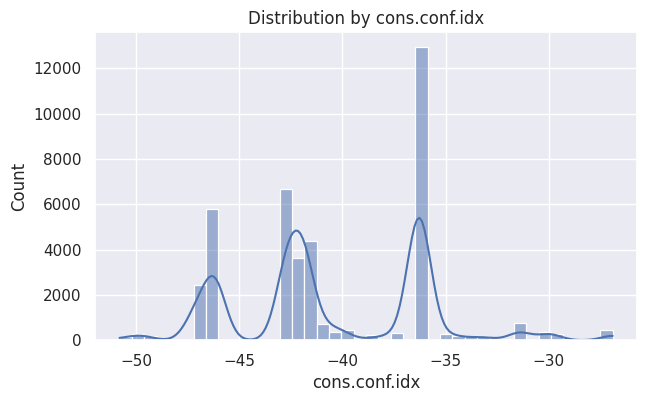

In [135]:
plt.figure(figsize=(7,4))
sns.histplot(df['cons.conf.idx'], bins=40, kde=True)
plt.title('Distribution by cons.conf.idx')

Text(0, 0.5, 'subscription')

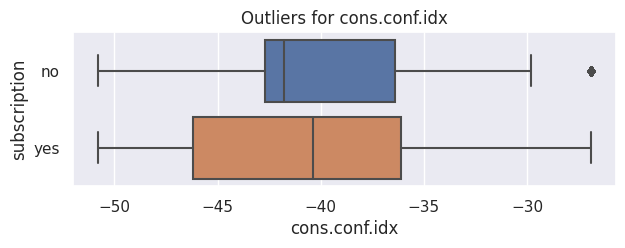

In [133]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="cons.conf.idx", y="y")
plt.title('Outliers for cons.conf.idx')
plt.ylabel('subscription')

Text(0.5, 1.0, 'Outliers for cons.conf.idx')

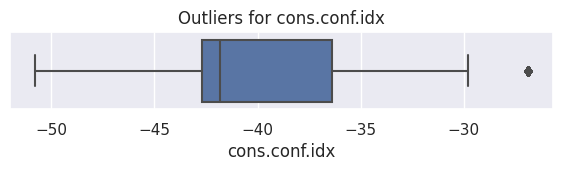

In [139]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x='cons.conf.idx')
plt.title('Outliers for cons.conf.idx')

In [149]:
df[df['cons.conf.idx'] == -26.9]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38154,50,management,married,university.degree,no,yes,no,cellular,oct,thu,...,2,4,1,success,-3.4,92.431,-26.9,0.754,5017.5,yes
38155,37,admin.,single,university.degree,no,yes,no,cellular,oct,thu,...,3,999,0,nonexistent,-3.4,92.431,-26.9,0.754,5017.5,yes
38156,59,technician,single,basic.6y,no,no,no,cellular,oct,thu,...,1,999,2,failure,-3.4,92.431,-26.9,0.754,5017.5,no
38157,31,admin.,married,university.degree,no,yes,no,cellular,oct,thu,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.754,5017.5,no
38158,35,admin.,married,high.school,no,yes,no,cellular,oct,thu,...,1,4,1,success,-3.4,92.431,-26.9,0.754,5017.5,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38596,69,retired,married,basic.4y,no,yes,yes,cellular,oct,fri,...,3,999,0,nonexistent,-3.4,92.431,-26.9,0.720,5017.5,yes
38597,18,student,single,basic.6y,no,no,yes,cellular,oct,fri,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.720,5017.5,yes
38598,59,retired,divorced,basic.4y,no,yes,no,telephone,oct,fri,...,4,999,0,nonexistent,-3.4,92.431,-26.9,0.720,5017.5,no
38599,37,admin.,single,university.degree,no,no,no,cellular,oct,fri,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.720,5017.5,yes


#### euribor3m

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(df['cons.conf.idx'], bins=40, kde=True)
plt.title('Distribution by cons.conf.idx')

#### nr.employed

In [ ]:
df = df.drop_duplicates()
df.shape

(44400, 13)

- summary
    - all the numerical features have outliers, in case of poor model preformance we can try winsorizing
- corellation with Y
- cross corellation

### Categorical features

In [ ]:
cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome", "y"]

In [ ]:
for col in cat_cols:
  print(df[col].value_counts(), '\n')

blue-collar      9570
management       9153
technician       7426
admin.           5111
services         4102
retired          2238
self-employed    1573
entrepreneur     1479
unemployed       1297
housemaid        1228
student           936
unknown           287
Name: job, dtype: int64 

married     26655
single      12585
divorced     5160
Name: marital, dtype: int64 

secondary    22831
tertiary     12961
primary       6757
unknown       1851
Name: education, dtype: int64 

no     43588
yes      812
Name: default, dtype: int64 

yes    24796
no     19604
Name: housing, dtype: int64 

no     37188
yes     7212
Name: loan, dtype: int64 

cellular     28655
unknown      12849
telephone     2896
Name: contact, dtype: int64 

unknown    36148
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64 

no     39118
yes     5282
Name: y, dtype: int64 



Our target feature is pretty unbalanced, need to take this in acount during test/train split. Target feature is categorical, model should solve classification task.

Besides that there are plenty records with unknown.

#### Dealing with unknown ~ N/A values

In [ ]:
df[df["job"] == 'unknown']

,age,job,marital,education,default,balance,housing,loan,contact,pdays,previous,poutcome,y
4,33,unknown,single,unknown,no,1,no,no,unknown,-1,0,unknown,no
216,47,unknown,married,unknown,no,28,no,no,unknown,-1,0,unknown,no
354,59,unknown,divorced,unknown,no,27,no,no,unknown,-1,0,unknown,no
876,37,unknown,single,unknown,no,414,yes,no,unknown,-1,0,unknown,no
1072,29,unknown,single,primary,no,50,yes,no,unknown,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44714,45,unknown,married,tertiary,no,406,no,no,cellular,-1,0,unknown,yes
44742,64,unknown,married,unknown,no,2799,no,no,telephone,-1,0,unknown,no
44970,28,unknown,single,unknown,no,326,no,no,cellular,231,1,success,yes
45141,77,unknown,married,unknown,no,397,no,no,telephone,185,3,success,no


In [ ]:
# TODO What to do with unknown?
# - delete
# - set to mean/mode
# - predict

Categorical feature labeling type:
* job          nominal label
* marital      nominal label
* education    ordinal label
* default      nominal label
* housing      nominal label
* loan         nominal label
* contact      nominal label
* poutcome     nominal label
* y            nominal label

In [ ]:
# TODO candidates algorithm for model (forest etc)
Logistic regression
Decision tree
Random forest
Support vector machine
K nearest neighbours
Naive Bayes

Ansamble of models?
# TODO hyperparameter optimization
# TODO Cross validation strategy?
# TODO Confusion matrix

порахувати тренувальні, валідаційні і тестові метрики

зробити висновки з коротким описом, чому обрали саме ту чи іншу модель,
метрики, проаналізувати, як вдалося покращити результати протягом валідації